## The Proposed Model - AlexNet_S

In [1]:
%%capture
import keras, matplotlib, os, math
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator

# Assign the GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2" 

### 1.Prepare data

In [2]:
# Load the train dataset
start_time = time()
print('Loading X_train...')
X_train = np.load('/home/zxt/data/final_22/224/5k/X_train.npy')
end_time = time()
print('Running time: %s seconds'%(end_time - start_time))

Loading X_train...
Running time: 845.9715702533722 seconds


In [3]:
len(X_train)

88000

In [4]:
# Load the validate, test datasets, all label data sets 
start_time = time()

print('Loading X_validate...')
X_validate = np.load('/home/zxt/data/final_22/224/5k/X_validate.npy')
print('Loading X_test...')
X_test = np.load('/home/zxt/data/final_22/224/5k/X_test.npy')
print('Loading labels...')
Y_train = np.load('/home/zxt/data/final_22/224/5k/Y_train.npy')
Y_validate = np.load('/home/zxt/data/final_22/224/5k/Y_validate.npy')
Y_test = np.load('/home/zxt/data/final_22/224/5k/Y_test.npy')

end_time = time()
print('Running time: %s seconds'%(end_time - start_time))

Loading X_validate...
Loading X_test...
Loading labels...
Running time: 212.54451751708984 seconds


In [5]:
# Check the size
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (88000, 224, 224, 3)
88000 train samples
11000 validate samples
11000 test samples


In [6]:
Y_train.shape

(88000, 1)

In [7]:
Y_validate.shape

(11000, 1)

In [8]:
Y_test.shape

(11000, 1)

In [9]:
# Data Normalization
X_train /=255.
X_validate /=  255.
X_test /= 255.

In [10]:
# Check the original labels
Y_test

array([['fox'],
       ['skunk'],
       ['wildebeest'],
       ...,
       ['zebra'],
       ['buffalo'],
       ['racoon']], dtype='<U16')

In [11]:
# Prepare for one-hot encoding
# Y_train label
for i in Y_train:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='coyote':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19
    if i[0]=='racoon':
        i[0]=20
    if i[0]=='empty':
        i[0]=21
        
for i in Y_validate:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='coyote':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19
    if i[0]=='racoon':
        i[0]=20
    if i[0]=='empty':
        i[0]=21

for i in Y_test:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='coyote':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19
    if i[0]=='racoon':
        i[0]=20
    if i[0]=='empty':
        i[0]=21

In [12]:
# Transform the Y_train, Y_validate, Y_test to One-hot encoder
from keras.utils import np_utils
y_train=np_utils.to_categorical(Y_train,22)
y_valid=np_utils.to_categorical(Y_validate,22)
y_test=np_utils.to_categorical(Y_test,22)

In [13]:
# Check the one-hot encoding transformation
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

### 2.Model structure

In [14]:
# Defind the AlexNet_S model architecture
def alexnet_s(input_shape, n_classes):
    input = Input(input_shape)
  
    '''Actually batch normalization didn't exist back then in 2012,
       they used LRN (Local Response Normalization) for regularization,
       now the BatchNormalization works the same
    '''
    x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Conv2D(256, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
    x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    
    # S: add two more layers to train
    x = Dropout(0.4)(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(4096,activation='relu')(x)
    
  
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model

In [ ]:
# prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#### 3*.Data Augmentation

In [ ]:
# Data augmentation [Not being used for the final model as it requires 250GB+ ram which exceeds our maximum 208GB ram; but can work on 44000 samples]

image_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.6,1),
    fill_mode="nearest")

image_datagen.fit(X_train, augment=True)

### 3.Modeling

In [19]:
# Define the hyperparameters
num_train_samples = len(Y_train)
num_val_samples = len(Y_validate)
batch_size = 128
epochs = 40
n_classes = 22
input_shape = 224,224,3

learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [20]:
# Present the model summary
K.clear_session()
model  = None
model = alexnet_s(input_shape, n_classes)
model.summary()

In [21]:
# Compile the model
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [22]:
# Model Training
start_time = time()
print('Training model...')

hist = model.fit(
    X_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
#     callbacks=[early_stopping],
    validation_data = (X_validate,y_valid))

end_time = time()
print('Running time: %s seconds'%(end_time - start_time))

Training model...
Train on 88000 samples, validate on 11000 samples
Epoch 1/40
88000/88000 [==============================] - 425s 5ms/step - loss: 1.5821 - accuracy: 0.4660 - val_loss: 1.2058 - val_accuracy: 0.5825
Epoch 2/40
88000/88000 [==============================] - 419s 5ms/step - loss: 1.0274 - accuracy: 0.6476 - val_loss: 1.1144 - val_accuracy: 0.6147
Epoch 3/40
88000/88000 [==============================] - 420s 5ms/step - loss: 0.8015 - accuracy: 0.7259 - val_loss: 0.7843 - val_accuracy: 0.7281
Epoch 4/40
88000/88000 [==============================] - 417s 5ms/step - loss: 0.6403 - accuracy: 0.7816 - val_loss: 0.6415 - val_accuracy: 0.7804
Epoch 5/40
88000/88000 [==============================] - 414s 5ms/step - loss: 0.5249 - accuracy: 0.8194 - val_loss: 0.6294 - val_accuracy: 0.7823
Epoch 6/40
88000/88000 [==============================] - 412s 5ms/step - loss: 0.4248 - accuracy: 0.8539 - val_loss: 0.5392 - val_accuracy: 0.8215
Epoch 7/40
88000/88000 [====================

In [23]:
# Save the model package
model.save('/home/zxt/model_files/alexnet_s_40epoch.h5')
model.save_weights('/home/zxt/model_files/alexnet_s_40epoch_weights.h5')
model.save_weights('/home/zxt/model_files/alexnet_s_40epoch_weights.ckpt')

### 4.Evaluation

In [24]:
# Observe the training iterations loss/accuracy plot
history_df = pd.DataFrame(hist.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

### 5.Prediction on X_test dataset

In [25]:
# Check the predcition accuracy on test data set
loss,accuracy = model.evaluate(X_test,y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

11000/11000 [==============================] - 30s 3ms/step

test loss 0.6951521164311774
accuracy 0.9008181691169739


In [26]:
y_pred = model.predict(X_test,batch_size=1)

In [27]:
y_pred

array([[2.11744388e-15, 3.55389294e-11, 1.32219092e-13, ...,
        5.50069856e-09, 7.36056505e-09, 9.29108526e-11],
       [2.59492217e-29, 7.06001134e-19, 6.92429785e-28, ...,
        1.79426693e-19, 1.41981773e-23, 8.57712670e-27],
       [2.74018530e-05, 2.41039115e-14, 9.35155622e-05, ...,
        2.65202806e-17, 1.61754967e-11, 3.48511567e-05],
       ...,
       [5.57477360e-05, 7.88359991e-14, 4.68837989e-11, ...,
        3.76579625e-15, 2.46456975e-14, 1.82276153e-07],
       [1.14163306e-07, 8.62780415e-17, 4.69466163e-20, ...,
        1.48811715e-20, 3.23430305e-21, 1.63550740e-18],
       [1.81745509e-15, 2.25600093e-14, 3.97152033e-11, ...,
        3.85610597e-14, 9.99998450e-01, 1.17957491e-07]], dtype=float32)

In [28]:
len(y_pred)

11000

### 6.Check each category recall

In [29]:
# Check each class recall for the bar chart of the report
a = list(y_pred)
y_prediction=[]
for i in a:
    j =list(i)
    y_prediction.append(j.index(max(j)))

In [30]:
y_prediction[:5]

[9, 16, 18, 10, 3]

In [31]:
Y_test[:5]

array([['9'],
       ['16'],
       ['14'],
       ['10'],
       ['3']], dtype='<U16')

In [32]:
# array to dataframe
y_real=pd.DataFrame(Y_test,columns=['label'])

In [33]:
y_predict = pd.DataFrame(y_prediction,columns=['label_pre'])

In [34]:
prediction_df = pd.concat([y_real,y_predict],axis=1)
prediction_df['label']=prediction_df['label'].astype(int)
prediction_df['diff']=prediction_df['label']-prediction_df['label_pre']


In [35]:
prediction_df

,label,label_pre,diff
0,9,9,0
1,16,16,0
2,14,18,-4
3,10,10,0
4,3,3,0
...,...,...,...
10995,0,10,-10
10996,15,15,0
10997,18,18,0
10998,11,11,0


In [36]:
# Save the correctly and wrongly classified observation information
prediction_df.to_csv(r'/home/zxt/data/final_22/prediction/alexnet_s_predictdiff.csv',index=False)

In [37]:
onehot_keylist = ['elephant','wild_boar','gazellethomosons','squirrel','hedgehog','guineafowl','moose','coyote','bird',
                  'fox','giraffe','buffalo','hare','vehicle','wildebeest','cattle','skunk','lion','zebra','black_bear',
                  'racoon','empty']
onehot_dict = {'elephant':0,'wild_boar':1,'gazellethomosons':2,'squirrel':3,'hedgehog':4,'guineafowl':5,'moose':6,'coyote':7,
              'bird':8,'fox':9,'giraffe':10,'buffalo':11,'hare':12,'vehicle':13,'wildebeest':14,'cattle':15,'skunk':16,'lion':17,
              'zebra':18,'black_bear':19,'racoon':20,'empty':21}

for animal in onehot_keylist:
    name = animal
    animal = prediction_df[prediction_df['label']== onehot_dict[animal]]
    recall = animal.loc[:,'diff'].value_counts()[0]/len(animal)
    print("%s recall: %10.3f" %(name,recall) )

elephant recall:      0.878
wild_boar recall:      0.804
gazellethomosons recall:      0.932
squirrel recall:      0.930
hedgehog recall:      0.998
guineafowl recall:      0.965
moose recall:      0.992
coyote recall:      0.926
bird recall:      0.879
fox recall:      0.868
giraffe recall:      0.947
buffalo recall:      0.849
hare recall:      0.973
vehicle recall:      0.929
wildebeest recall:      0.777
cattle recall:      0.809
skunk recall:      0.924
lion recall:      0.830
zebra recall:      0.850
black_bear recall:      0.899
racoon recall:      0.958
empty recall:      0.904


### 7.Confusion Matrix

In [38]:
# Prepare for generating Confusion Matrix
animal_label_dict = {0:'elephant',1:'wild_boar',2:'gazellethomosons',3:'squirrel',4:'hedgehog',
                    5:'guineafowl',6:'moose',7:'coyote',8:'bird',9:'fox',10:'giraffe',
                    11:'buffalo',12:'hare',13:'vehicle',14:'wildebeest',15:'cattle',
                    16:'skunk',17:'lion',18:'zebra',19:'black_bear',20:'racoon',21:'empty'}     
labels=[]
for i in range(0,22):
    name = animal_label_dict[i]
    labels.append(name)

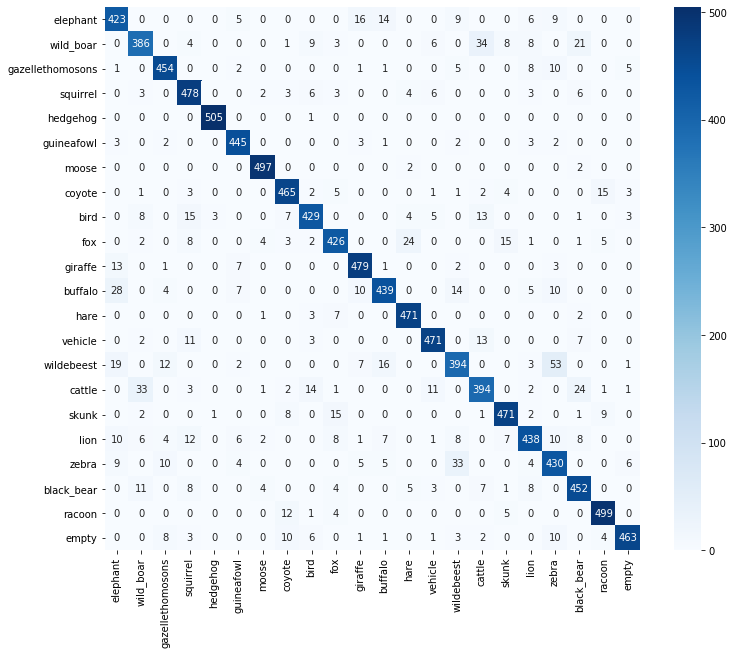

In [39]:
# Draw the Confusion Matrix 
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
# C2=confusion_matrix(test_true_label,prediction_label, labels=labels)
C2=confusion_matrix(prediction_df['label'],prediction_df['label_pre'], labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
plt.figure(figsize=(12,10))
sns.heatmap(C2,annot=True,cmap="Blues",xticklabels=labels,yticklabels=labels,fmt='.20g')

### 8.Precision, recall, f1 score

In [40]:
# Check each class exact precision, recall, f1 score and support
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(prediction_df['label'],prediction_df['label_pre']))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       482
           1       0.85      0.80      0.83       480
           2       0.92      0.93      0.92       487
           3       0.88      0.93      0.90       514
           4       0.99      1.00      1.00       506
           5       0.93      0.97      0.95       461
           6       0.97      0.99      0.98       501
           7       0.91      0.93      0.92       502
           8       0.90      0.88      0.89       488
           9       0.89      0.87      0.88       491
          10       0.92      0.95      0.93       506
          11       0.91      0.85      0.88       517
          12       0.92      0.97      0.95       484
          13       0.93      0.93      0.93       507
          14       0.84      0.78      0.81       507
          15       0.85      0.81      0.83       487
          16       0.92      0.92      0.92       510
          17       0.89    